In [2]:
import gspread
print(gspread.__version__)

3.0.1


In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [4]:
ss_url = "https://docs.google.com/spreadsheets/d/1u50kS8Ztmgjjs--S1AM4753quL3QEPRR7xIGjCxcSCw/edit#gid=941271295"

In [5]:
workbook = gc.open_by_url(ss_url)
workbook

<Spreadsheet 'Questionary' id:1u50kS8Ztmgjjs--S1AM4753quL3QEPRR7xIGjCxcSCw>

In [6]:
worksheet = workbook.get_worksheet(0)
worksheet

<Worksheet 'Form Responses 1' id:941271295>

In [7]:
import gspread_dataframe as gs_df
df = gs_df.get_as_dataframe(worksheet)
df

,Timestamp,Score,Pen name,Q1. Gender,Q2. 高校時代の英語の偏差値はどのくらい？,Q3. 高校時代の国語の偏差値はどのくらい？,Q4. 高校時代の数学の偏差値はどのくらい？,Q5. 高校時代の理科の偏差値はどのくらい？,Q6. 高校時代の社会の偏差値はどのくらい？,Q7. 高校時代の体育の成績を５段階評価で表すと？,Q8. 高校時代、勉強がどのくらい好きだったか５段階評価で,Q9. 浪人経験はありますか？,Q10. 今の大学は第一希望でしたか？,Q11. 今、実家暮らし？一人暮らし？,Q12. 大学への通学時間は？（単位：分）,Q13. 朝ごはんは週何回くらい食べてる？,Q14. １日あたりの睡眠時間は平均何時間？,Q15. 大学の成績(GPA)は？,Q16. 今、バイトは週何時間くらい？,Q17. 部活（またはサークル活動）は週何時間？,Q18. 彼氏または彼女はいる？,Q19. あなたはリア充ですか？５段階評価で,Unnamed: 22,Q20. 上記以外に、加えて欲しい質問項目などがありましたら教えてください。
0,5/18/2017 13:28:25,0.0,pp,男性 Male,50,50,55,60,60,4.0,3.0,ない（現役合格）,第二希望,実家,60,7,6,2.8,4,20,いる（２次元）,2.0,NaN,NaN
1,5/18/2017 13:28:37,0.0,chimp,男性 Male,70,60,70,70,60,4.0,3.0,ない（現役合格）,第一希望,実家,90,7,5,3.2,6.5,6,いない,1.0,NaN,NaN
2,5/18/2017 13:37:00,0.0,あんぱん,男性 Male,80,70,65,70,50,5.0,3.0,ない（現役合格）,第二希望,実家,90,7,6,2.4,0,15,いない,3.0,NaN,NaN
3,5/18/2017 13:40:12,0.0,あかさたな,男性 Male,40,50,55,55,50,3.0,3.0,ない（現役合格）,第一希望,一人,30,5,6,2,10,8,いる（リアル）,2.0,NaN,NaN
4,5/18/2017 13:37:35,0.0,rrr,男性 Male,65,60,70,65,50,5.0,3.0,１浪,第一希望,実家,120,7,6,2.8,12,2,いない,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df2 = df[~df['Timestamp'].isnull()]
df2

,Timestamp,Score,Pen name,Q1. Gender,Q2. 高校時代の英語の偏差値はどのくらい？,Q3. 高校時代の国語の偏差値はどのくらい？,Q4. 高校時代の数学の偏差値はどのくらい？,Q5. 高校時代の理科の偏差値はどのくらい？,Q6. 高校時代の社会の偏差値はどのくらい？,Q7. 高校時代の体育の成績を５段階評価で表すと？,Q8. 高校時代、勉強がどのくらい好きだったか５段階評価で,Q9. 浪人経験はありますか？,Q10. 今の大学は第一希望でしたか？,Q11. 今、実家暮らし？一人暮らし？,Q12. 大学への通学時間は？（単位：分）,Q13. 朝ごはんは週何回くらい食べてる？,Q14. １日あたりの睡眠時間は平均何時間？,Q15. 大学の成績(GPA)は？,Q16. 今、バイトは週何時間くらい？,Q17. 部活（またはサークル活動）は週何時間？,Q18. 彼氏または彼女はいる？,Q19. あなたはリア充ですか？５段階評価で,Unnamed: 22,Q20. 上記以外に、加えて欲しい質問項目などがありましたら教えてください。
0,5/18/2017 13:28:25,0.0,pp,男性 Male,50,50,55,60,60,4.0,3.0,ない（現役合格）,第二希望,実家,60,7,6,2.8,4,20,いる（２次元）,2.0,NaN,NaN
1,5/18/2017 13:28:37,0.0,chimp,男性 Male,70,60,70,70,60,4.0,3.0,ない（現役合格）,第一希望,実家,90,7,5,3.2,6.5,6,いない,1.0,NaN,NaN
2,5/18/2017 13:37:00,0.0,あんぱん,男性 Male,80,70,65,70,50,5.0,3.0,ない（現役合格）,第二希望,実家,90,7,6,2.4,0,15,いない,3.0,NaN,NaN
3,5/18/2017 13:40:12,0.0,あかさたな,男性 Male,40,50,55,55,50,3.0,3.0,ない（現役合格）,第一希望,一人,30,5,6,2,10,8,いる（リアル）,2.0,NaN,NaN
4,5/18/2017 13:37:35,0.0,rrr,男性 Male,65,60,70,65,50,5.0,3.0,１浪,第一希望,実家,120,7,6,2.8,12,2,いない,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,10/30/2021 14:47:44,0.0,Blackstar,男性 Male,70,70,60,65,70,2.0,2.0,１浪,第一希望,一人,20,7,6,不明,10,3,いない,3.0,NaN,NaN
968,10/31/2021 19:23:31,0.0,塩麴,男性 Male,65,65,65,65,65,4.0,4.0,１浪,第一希望,一人,105,7,7,3,10,4,いない,4.0,NaN,NaN
969,11/1/2021 23:03:55,0.0,わかし,男性 Male,60,60,65,60,60,4.0,4.0,ない（現役合格）,第一希望,一人,10,3,6,不明,0,2,いる（リアル）,3.0,NaN,NaN
970,11/4/2021 11:46:38,0.0,るんば,男性 Male,70,70,70,70,70,4.0,4.0,ない（現役合格）,第一希望,一人,30,5,4,3,9,0,いない,4.0,NaN,NaN


TypeError: ignored

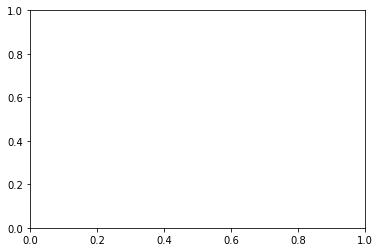

In [41]:
# 数字を入力すべき場所に数字ではない文字が入力されているなどのエラーにより、計算ができない

df2["Q12. 大学への通学時間は？（単位：分）"].hist()

In [42]:
df2["Q12. 大学への通学時間は？（単位：分）"].astype("float").hist()

ValueError: ignored

In [66]:
# 入力エラーを起こしてる人のデータを使わないことにする

clean_data = []
for data in df.values:
    contains_error = False
    for i in [4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21]: # these columns should be numeric
        if pd.isnull(data[i]):
            contains_error = True
            break
        try:
            data[i] = float(data[i])
        except:
            contains_error = True
            break
    if contains_error:
        continue
    else:
        clean_data.append(data)

In [44]:
import pandas as pd

df3 = pd.DataFrame(clean_data)
df3.columns = df2.columns
df3

,Timestamp,Score,Pen name,Q1. Gender,Q2. 高校時代の英語の偏差値はどのくらい？,Q3. 高校時代の国語の偏差値はどのくらい？,Q4. 高校時代の数学の偏差値はどのくらい？,Q5. 高校時代の理科の偏差値はどのくらい？,Q6. 高校時代の社会の偏差値はどのくらい？,Q7. 高校時代の体育の成績を５段階評価で表すと？,Q8. 高校時代、勉強がどのくらい好きだったか５段階評価で,Q9. 浪人経験はありますか？,Q10. 今の大学は第一希望でしたか？,Q11. 今、実家暮らし？一人暮らし？,Q12. 大学への通学時間は？（単位：分）,Q13. 朝ごはんは週何回くらい食べてる？,Q14. １日あたりの睡眠時間は平均何時間？,Q15. 大学の成績(GPA)は？,Q16. 今、バイトは週何時間くらい？,Q17. 部活（またはサークル活動）は週何時間？,Q18. 彼氏または彼女はいる？,Q19. あなたはリア充ですか？５段階評価で,Unnamed: 22,Q20. 上記以外に、加えて欲しい質問項目などがありましたら教えてください。
0,5/18/2017 13:28:25,0.0,pp,男性 Male,50.0,50.0,55.0,60.0,60.0,4.0,3.0,ない（現役合格）,第二希望,実家,60.0,7.0,6.0,2.8,4.0,20.0,いる（２次元）,2.0,NaN,NaN
1,5/18/2017 13:28:37,0.0,chimp,男性 Male,70.0,60.0,70.0,70.0,60.0,4.0,3.0,ない（現役合格）,第一希望,実家,90.0,7.0,5.0,3.2,6.5,6.0,いない,1.0,NaN,NaN
2,5/18/2017 13:37:00,0.0,あんぱん,男性 Male,80.0,70.0,65.0,70.0,50.0,5.0,3.0,ない（現役合格）,第二希望,実家,90.0,7.0,6.0,2.4,0.0,15.0,いない,3.0,NaN,NaN
3,5/18/2017 13:40:12,0.0,あかさたな,男性 Male,40.0,50.0,55.0,55.0,50.0,3.0,3.0,ない（現役合格）,第一希望,一人,30.0,5.0,6.0,2.0,10.0,8.0,いる（リアル）,2.0,NaN,NaN
4,5/18/2017 13:37:35,0.0,rrr,男性 Male,65.0,60.0,70.0,65.0,50.0,5.0,3.0,１浪,第一希望,実家,120.0,7.0,6.0,2.8,12.0,2.0,いない,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,10/18/2021 14:16:58,0.0,山田,女性 Female,80.0,70.0,75.0,75.0,65.0,4.0,2.0,ない（現役合格）,第一希望,実家,45.0,6.0,6.0,3.0,7.0,0.0,いる（リアル）,3.0,NaN,NaN
858,10/23/2021 21:16:10,0.0,カッキー,男性 Male,75.0,81.0,78.0,76.0,72.0,2.0,4.0,ない（現役合格）,第一希望,一人,25.0,2.0,6.0,2.0,0.0,0.0,いる（リアル）,5.0,NaN,NaN
859,10/29/2021 23:15:12,0.0,mk,男性 Male,65.0,65.0,75.0,75.0,65.0,1.0,2.0,ない（現役合格）,第一希望,一人,40.0,4.0,8.0,3.0,20.0,4.0,いない,2.0,NaN,NaN
860,10/31/2021 19:23:31,0.0,塩麴,男性 Male,65.0,65.0,65.0,65.0,65.0,4.0,4.0,１浪,第一希望,一人,105.0,7.0,7.0,3.0,10.0,4.0,いない,4.0,NaN,NaN


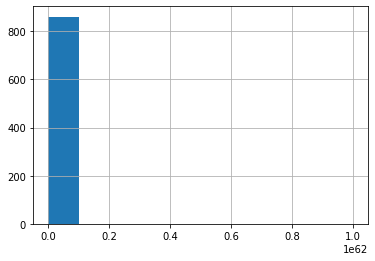

In [67]:
# 異常に大きい数字など（外れ値）を入力してる人などの影響により、統計的な解釈ができない。

df3["Q12. 大学への通学時間は？（単位：分）"].hist()

In [70]:
# 外れ値を排除する（この方法がベストとは限らない）

outlier_df = pd.DataFrame()

colnames = [
            "Q12. 大学への通学時間は？（単位：分）",
            "Q13. 朝ごはんは週何回くらい食べてる？",
            "Q14. １日あたりの睡眠時間は平均何時間？",
            "Q15. 大学の成績(GPA)は？",
            "Q16. 今、バイトは週何時間くらい？",
            "Q17. 部活（またはサークル活動）は週何時間？"
            ]

for colname in colnames:
    outlier_min = df3[colname].describe()['50%'] - df3[colname].describe()['25%'] * 5
    outlier_max = df3[colname].describe()['50%'] + df3[colname].describe()['75%'] * 5
    outlier = df3[colname].apply(lambda x: x <= outlier_min or x >= outlier_max)
    outlier_df[colname] = outlier

outlier_df

,Q12. 大学への通学時間は？（単位：分）,Q13. 朝ごはんは週何回くらい食べてる？,Q14. １日あたりの睡眠時間は平均何時間？,Q15. 大学の成績(GPA)は？,Q16. 今、バイトは週何時間くらい？,Q17. 部活（またはサークル活動）は週何時間？
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,True
...,...,...,...,...,...,...
857,False,False,False,False,False,True
858,False,False,False,False,False,True
859,False,False,False,False,False,True
860,False,False,False,False,False,True


In [71]:
print(list(outlier_df.sum(axis=1)))

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 1, 3, 4, 2, 3, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 3, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, 

In [72]:
valid_ids = [i for i, x in enumerate(list(outlier_df.sum(axis=1))) if x == 0]
print(valid_ids)

[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 14, 16, 18, 19, 20, 21, 22, 26, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 72, 74, 75, 76, 82, 86, 88, 91, 93, 96, 101, 102, 104, 116, 117, 119, 122, 124, 125, 126, 128, 130, 131, 133, 136, 139, 140, 141, 142, 144, 151, 152, 153, 155, 156, 157, 158, 161, 166, 167, 168, 170, 171, 172, 173, 174, 176, 177, 178, 182, 183, 186, 188, 190, 191, 192, 195, 198, 199, 201, 202, 204, 205, 206, 214, 215, 217, 222, 226, 230, 233, 234, 239, 243, 244, 245, 246, 250, 251, 252, 254, 257, 259, 260, 261, 267, 268, 269, 271, 272, 273, 276, 278, 279, 282, 286, 288, 291, 296, 299, 305, 308, 311, 313, 314, 315, 317, 318, 322, 323, 326, 330, 334, 337, 342, 345, 348, 349, 353, 356, 359, 361, 363, 364, 366, 367, 368, 369, 370, 374, 375, 376, 377, 383, 391, 392, 396, 397, 398, 399, 403, 404, 405, 406, 407, 409, 410, 412, 413, 414, 415, 419, 421, 423, 426, 427, 428, 430, 434, 435, 441, 

In [73]:
df4 = df3.iloc[valid_ids, :]
df4

,Timestamp,Score,Pen name,Q1. Gender,Q2. 高校時代の英語の偏差値はどのくらい？,Q3. 高校時代の国語の偏差値はどのくらい？,Q4. 高校時代の数学の偏差値はどのくらい？,Q5. 高校時代の理科の偏差値はどのくらい？,Q6. 高校時代の社会の偏差値はどのくらい？,Q7. 高校時代の体育の成績を５段階評価で表すと？,Q8. 高校時代、勉強がどのくらい好きだったか５段階評価で,Q9. 浪人経験はありますか？,Q10. 今の大学は第一希望でしたか？,Q11. 今、実家暮らし？一人暮らし？,Q12. 大学への通学時間は？（単位：分）,Q13. 朝ごはんは週何回くらい食べてる？,Q14. １日あたりの睡眠時間は平均何時間？,Q15. 大学の成績(GPA)は？,Q16. 今、バイトは週何時間くらい？,Q17. 部活（またはサークル活動）は週何時間？,Q18. 彼氏または彼女はいる？,Q19. あなたはリア充ですか？５段階評価で,Unnamed: 22,Q20. 上記以外に、加えて欲しい質問項目などがありましたら教えてください。
0,5/18/2017 13:28:25,0.0,pp,男性 Male,50.0,50.0,55.0,60.0,60.0,4.0,3.0,ない（現役合格）,第二希望,実家,60.0,7.0,6.0,2.8,4.0,20.0,いる（２次元）,2.0,NaN,NaN
1,5/18/2017 13:28:37,0.0,chimp,男性 Male,70.0,60.0,70.0,70.0,60.0,4.0,3.0,ない（現役合格）,第一希望,実家,90.0,7.0,5.0,3.2,6.5,6.0,いない,1.0,NaN,NaN
2,5/18/2017 13:37:00,0.0,あんぱん,男性 Male,80.0,70.0,65.0,70.0,50.0,5.0,3.0,ない（現役合格）,第二希望,実家,90.0,7.0,6.0,2.4,0.0,15.0,いない,3.0,NaN,NaN
3,5/18/2017 13:40:12,0.0,あかさたな,男性 Male,40.0,50.0,55.0,55.0,50.0,3.0,3.0,ない（現役合格）,第一希望,一人,30.0,5.0,6.0,2.0,10.0,8.0,いる（リアル）,2.0,NaN,NaN
5,5/18/2017 13:37:15,0.0,com,男性 Male,58.0,50.0,60.0,60.0,50.0,4.0,3.0,ない（現役合格）,第一希望,実家,90.0,7.0,7.0,2.6,2.0,10.0,いる（リアル）,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,10/5/2021 9:06:35,0.0,TaopaiPython,男性 Male,80.0,75.0,70.0,65.0,65.0,5.0,4.0,１浪,第一希望,一人,30.0,3.0,5.0,4.0,12.0,6.0,いない,2.0,NaN,NaN
822,10/5/2021 9:06:36,0.0,missahora,性別不詳 Unknown,90.0,94.0,72.0,82.0,70.0,5.0,5.0,１浪,第二希望,実家,50.0,7.0,8.0,3.9,1.0,6.0,いない,5.0,NaN,一日平均何歩程度、歩きますか？
828,10/5/2021 9:07:47,0.0,安倍晋三五郎三郎座右衛門,男性 Male,65.0,65.0,65.0,65.0,65.0,5.0,5.0,１浪,第一希望,一人,60.0,1.0,6.0,3.7,6.0,10.0,いる（リアル）,5.0,NaN,NaN
854,10/12/2021 0:56:37,0.0,くま,女性 Female,67.0,62.0,68.0,60.0,60.0,2.0,4.0,ない（現役合格）,第一希望,実家,50.0,7.0,5.5,3.8,8.0,10.0,いない,4.0,NaN,NaN


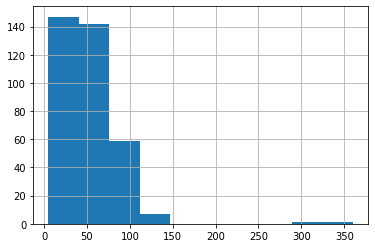

In [74]:
# これで、異常なデータは排除できた、かもしれない。

df4["Q12. 大学への通学時間は？（単位：分）"].hist()

In [75]:
# ここから先は、独自の視点で解析を頑張ってください。